In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Neural Network
import keras 
from keras.models import Sequential 
from keras.layers import Dense

# load the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df = df_train.append(df_test , ignore_index = True)

# some quick inspections
print(df_train.shape, df_test.shape, df_train.columns.values)

Using TensorFlow backend.


(891, 12) (418, 11) ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


C:\Users\HP-PC\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [2]:
df_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
575,576,0,3,"Patchett, Mr. George",male,19.0,0,0,358585,14.5000,NaN,S
548,549,0,3,"Goldsmith, Mr. Frank John",male,33.0,1,1,363291,20.5250,NaN,S
565,566,0,3,"Davies, Mr. Alfred J",male,24.0,2,0,A/4 48871,24.1500,NaN,S
123,124,1,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13.0000,E101,S
756,757,0,3,"Carlsson, Mr. August Sigfrid",male,28.0,0,0,350042,7.7958,NaN,S
783,784,0,3,"Johnston, Mr. Andrew G",male,NaN,1,2,W./C. 6607,23.4500,NaN,S
584,585,0,3,"Paulner, Mr. Uscher",male,NaN,0,0,3411,8.7125,NaN,C
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,E67,S
90,91,0,3,"Christmann, Mr. Emil",male,29.0,0,0,343276,8.0500,NaN,S
763,764,1,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S


### Pclass

In [3]:
# check if there is any NAN
df['Pclass'].isnull().sum(axis=0)

0

In [4]:
# inspect the correlation between Pclass and Survived
df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


We can see that a higher class (lower value) has a higher survival rate. This should be a very useful feature.

### Name

In [5]:
df.Name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [6]:
df['Title'] = df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())

# inspect the amount of people for each title
df['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Capt              1
Lady              1
Dona              1
Mme               1
Jonkheer          1
the Countess      1
Sir               1
Don               1
Name: Title, dtype: int64

Looks like the main ones are "Master", "Miss", "Mr", "Mrs". Some of the others can be be merged into some of these four categories. For the rest, I'll just call them "Others"

In [7]:
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace(['Mme','Lady','Ms'], 'Mrs')
df.Title.loc[ (df.Title !=  'Master') & (df.Title !=  'Mr') & (df.Title !=  'Miss') 
             & (df.Title !=  'Mrs')] = 'Others'

# inspect the correlation between Title and Survived
df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

C:\Users\HP-PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Title,Survived
0,Master,0.575000
1,Miss,0.701087
2,Mr,0.156673
3,Mrs,0.796875
4,Others,0.318182


In [8]:
# inspect the amount of people for each title
df['Title'].value_counts()

Mr        757
Miss      262
Mrs       201
Master     61
Others     28
Name: Title, dtype: int64

In [9]:
df = pd.concat([df, pd.get_dummies(df['Title'])], axis=1).drop(labels=['Name'], axis=1)

In [10]:
df

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Master,Miss,Mr,Mrs,Others
0,22.0,NaN,S,7.2500,0,1,3,male,1,0.0,A/5 21171,Mr,0,0,1,0,0
1,38.0,C85,C,71.2833,0,2,1,female,1,1.0,PC 17599,Mrs,0,0,0,1,0
2,26.0,NaN,S,7.9250,0,3,3,female,0,1.0,STON/O2. 3101282,Miss,0,1,0,0,0
3,35.0,C123,S,53.1000,0,4,1,female,1,1.0,113803,Mrs,0,0,0,1,0
4,35.0,NaN,S,8.0500,0,5,3,male,0,0.0,373450,Mr,0,0,1,0,0
5,NaN,NaN,Q,8.4583,0,6,3,male,0,0.0,330877,Mr,0,0,1,0,0
6,54.0,E46,S,51.8625,0,7,1,male,0,0.0,17463,Mr,0,0,1,0,0
7,2.0,NaN,S,21.0750,1,8,3,male,3,0.0,349909,Master,1,0,0,0,0
8,27.0,NaN,S,11.1333,2,9,3,female,0,1.0,347742,Mrs,0,0,0,1,0
9,14.0,NaN,C,30.0708,0,10,2,female,1,1.0,237736,Mrs,0,0,0,1,0


### Sex

In [11]:
# check if there is any NAN
df.Sex.isnull().sum(axis=0)

0

In [12]:
# inspect the correlation between Sex and Survived
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
# map the two genders to 0 and 1
df.Sex = df.Sex.map({'male':0, 'female':1})

### Age

In [14]:
# check if there is any NAN
df.Age.isnull().sum(axis=0)

263

### SibSp and Parch

In [15]:
# check if there is any NAN
df.SibSp.isnull().sum(axis=0), df.Parch.isnull().sum(axis=0)

(0, 0)

In [16]:
# create a new feature "Family"
df['Family'] = df['SibSp'] + df['Parch'] + 1

# inspect the correlation between Family and Survived
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [17]:
# inspect the amount of people for each Family size
df['Family'].value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

In [18]:
df.Family = df.Family.map(lambda x: 0 if x > 4 else x)
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,0,0.161290
1,1,0.303538
2,2,0.552795
3,3,0.578431
4,4,0.724138


In [19]:
df['Family'].value_counts()

1    790
2    235
3    159
0     82
4     43
Name: Family, dtype: int64

### Ticket

In [20]:
# check if there is any NAN
df.Ticket.isnull().sum(axis=0)

0

In [21]:
df.Ticket.head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

In [22]:
df.Ticket = df.Ticket.map(lambda x: x[0])

# inspect the correlation between Ticket and Survived
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.200000
4,5,0.000000
5,6,0.166667
6,7,0.111111
7,8,0.000000
8,9,1.000000
9,A,0.068966


In [23]:
# inspect the amount of people for each type of tickets
df['Ticket'].value_counts()

3    429
2    278
1    210
P     98
S     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket, dtype: int64

In [24]:
df[['Ticket', 'Fare']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Fare
0,1,65.771211
1,2,20.235194
2,3,15.380682
3,4,16.764036
4,5,19.262500
5,6,19.153711
6,7,9.197438
7,8,8.397900
8,9,7.750000
9,A,10.189681


In [25]:
df[['Ticket', 'Pclass']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Pclass
0,1,1.147619
1,2,2.309353
2,3,2.904429
3,4,3.000000
4,5,2.333333
5,6,2.111111
6,7,3.000000
7,8,3.000000
8,9,3.000000
9,A,3.000000


### Fare

In [26]:
# check if there is any NAN
df.Fare.isnull().sum(axis=0)

1

In [27]:
df.Ticket[df.Fare.isnull()]

1043    3
Name: Ticket, dtype: object

In [28]:
df.Pclass[df.Fare.isnull()]

1043    3
Name: Pclass, dtype: int64

In [29]:
df.Cabin[df.Fare.isnull()]

1043    NaN
Name: Cabin, dtype: object

In [30]:
df.Embarked[df.Fare.isnull()]

1043    S
Name: Embarked, dtype: object

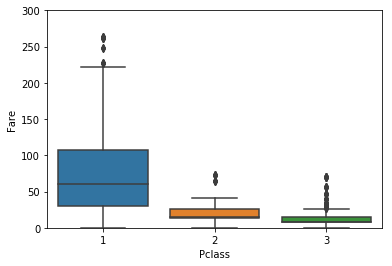

In [31]:
# use boxplot to visualize the distribution of Fare for each Pclass
sns.boxplot('Pclass','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [32]:
# inspect the correlation between Pclass and Fare
df[['Pclass', 'Fare']].groupby(['Pclass']).mean()

,Fare
Pclass,
1,87.508992
2,21.179196
3,13.302889


In [33]:
# divide the standard deviation by the mean. A lower ratio means a tighter 
# distribution of Fare in each Pclass
df[['Pclass', 'Fare']].groupby(['Pclass']).std() / df[['Pclass', 'Fare']].groupby(['Pclass']).mean()

,Fare
Pclass,
1,0.919302
2,0.642476
3,0.864050


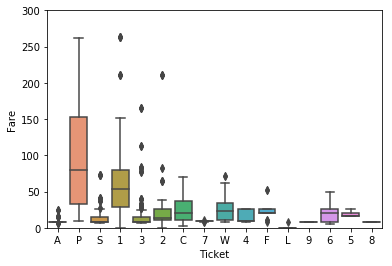

In [34]:
# use boxplot to visualize the distribution of Fare for each Ticket
sns.boxplot('Ticket','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [35]:
# inspect the correlation between Ticket and Fare 
# (we saw this earlier)
df[['Ticket', 'Fare']].groupby(['Ticket']).mean()

,Fare
Ticket,
1,65.771211
2,20.235194
3,15.380682
4,16.764036
5,19.262500
6,19.153711
7,9.197438
8,8.397900
9,7.750000


In [36]:
# divide the standard deviation by the mean. A lower ratio means a tighter 
# distribution of Fare in each Ticket type
df[['Ticket', 'Fare']].groupby(['Ticket']).std() /  df[['Ticket', 'Fare']].groupby(['Ticket']).mean()

,Fare
Ticket,
1,0.817411
2,1.284139
3,1.351244
4,0.497578
5,0.284367
6,0.735873
7,0.080078
8,0.005961
9,0.000000


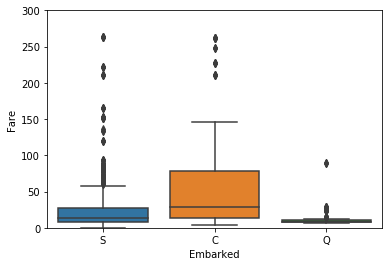

In [37]:
# use boxplot to visualize the distribution of Fare for each Embarked
sns.boxplot('Embarked','Fare',data=df)
plt.ylim(0, 300) # ignore one data point with Fare > 500
plt.show()

In [38]:
# inspect the correlation between Embarked and Fare
df[['Embarked', 'Fare']].groupby(['Embarked']).mean()

,Fare
Embarked,
C,62.336267
Q,12.409012
S,27.418824


In [39]:
# divide the standard deviation by the mean. A lower ratio means a tighter 
# distribution of Fare in each Embarked
df[['Embarked', 'Fare']].groupby(['Embarked']).std() /  df[['Embarked', 'Fare']].groupby(['Embarked']).mean()

,Fare
Embarked,
C,1.350514
Q,1.097278
S,1.352954


Looks like Fare indeed has correlation with these three features. I'll guess the missing value using the median value of (Pcalss = 3) & (Ticket = 3) & (Embarked = S)

In [40]:
guess_Fare = df.Fare.loc[ (df.Ticket == '3') & (df.Pclass == 3) & (df.Embarked == 'S')].median()
df.Fare.fillna(guess_Fare , inplace=True)

# inspect the mean Fare values for people who died and survived
df[['Fare', 'Survived']].groupby(['Survived'],as_index=False).mean()

,Survived,Fare
0,0.0,22.117887
1,1.0,48.395408


C:\Users\HP-PC\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


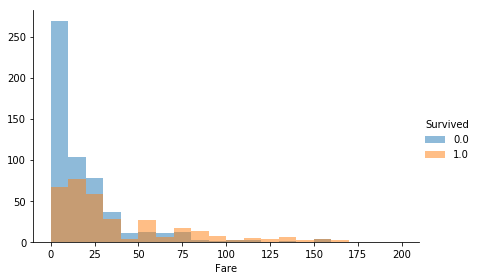

In [41]:
# visualize the distribution of Fare for people who survived and died
grid = sns.FacetGrid(df, hue='Survived', size=4, aspect=1.5)
grid.map(plt.hist, 'Fare', alpha=.5, bins=range(0,210,10))
grid.add_legend()
plt.show()

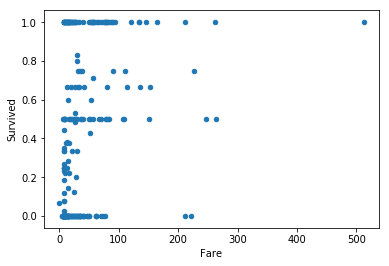

In [42]:
# visualize the correlation between Fare and Survived using a scatter plot
df[['Fare', 'Survived']].groupby(['Fare'],as_index=False).mean().plot.scatter('Fare','Survived')
plt.show()

We can see that people with lower Fare are less likely to survive. But this is certainly not a smooth curve if we don't bin the data. It would be better to feed machine learning algorithms with intervals of Fare, because using the original Fare values would likely cause over-fitting. 

In [43]:
# bin Fare into five intervals with equal amount of people
df['Fare-bin'] = pd.qcut(df.Fare,5,labels=[1,2,3,4,5]).astype(int)

# inspect the correlation between Fare-bin and Survived
df[['Fare-bin', 'Survived']].groupby(['Fare-bin'], as_index=False).mean()

,Fare-bin,Survived
0,1,0.217877
1,2,0.201087
2,3,0.426901
3,4,0.443243
4,5,0.645349


Now the correlation is clear after binning the data!

### Cabin

In [44]:
# check if there is any NAN
df.Cabin.isnull().sum(axis=0)

1014

In [45]:
df = df.drop(labels=['Cabin'], axis=1)

### Embarked

In [46]:
# check if there is any NAN
df.Embarked.isnull().sum(axis=0)

2

In [47]:
df.describe(include=['O']) # S is the most common

,Embarked,Ticket,Title
count,1307,1309,1309
unique,3,16,5
top,S,3,Mr
freq,914,429,757


In [48]:
# fill the NAN
df.Embarked.fillna('S' , inplace=True )

In [49]:
# inspect the correlation between Embarked and Survived as well as some other features
df[['Embarked', 'Survived','Pclass','Fare', 'Age', 'Sex']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived,Pclass,Fare,Age,Sex
0,C,0.553571,1.851852,62.336267,32.332170,0.418519
1,Q,0.389610,2.894309,12.409012,28.630000,0.487805
2,S,0.339009,2.344978,27.512485,29.298151,0.319869


In [50]:
df = df.drop(labels='Embarked', axis=1)

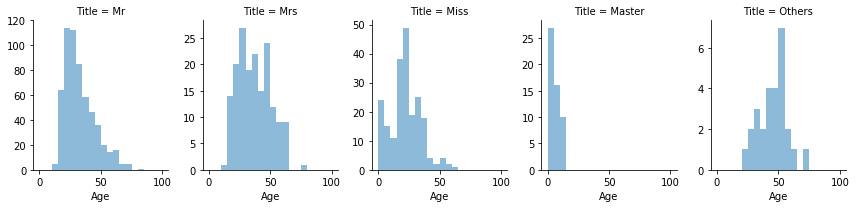

In [51]:
# visualize the correlation between Title and Age
grid = sns.FacetGrid(df, col='Title', size=3, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [52]:
# inspect the mean Age for each Title
df[['Title', 'Age']].groupby(['Title']).mean()

,Age
Title,
Master,5.482642
Miss,21.795236
Mr,32.252151
Mrs,36.930636
Others,45.074074


In [53]:
# inspect the standard deviation of Age for each Title
df[['Title', 'Age']].groupby(['Title']).std()

,Age
Title,
Master,4.161554
Miss,12.192794
Mr,12.422089
Mrs,12.872625
Others,11.303253


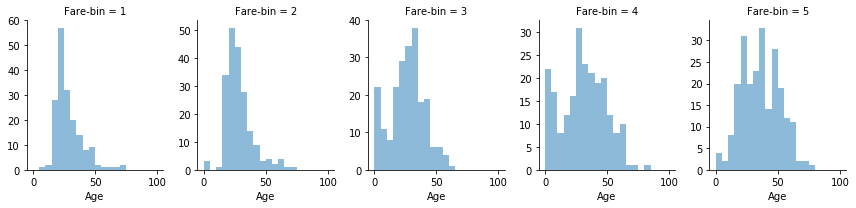

In [54]:
# visualize the correlation between Fare-bin and Age
grid = sns.FacetGrid(df, col='Fare-bin', size=3, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [55]:
# inspect the mean Age for each Fare-bin
df[['Fare-bin', 'Age']].groupby(['Fare-bin']).mean()

,Age
Fare-bin,
1,27.848315
2,27.898241
3,26.144009
4,30.728604
5,35.877913


In [56]:
# inspect the standard deviation of Age for each Fare-bin
df[['Fare-bin', 'Age']].groupby(['Fare-bin']).std()

,Age
Fare-bin,
1,10.812580
2,10.995650
3,13.523208
4,17.466022
5,15.150724


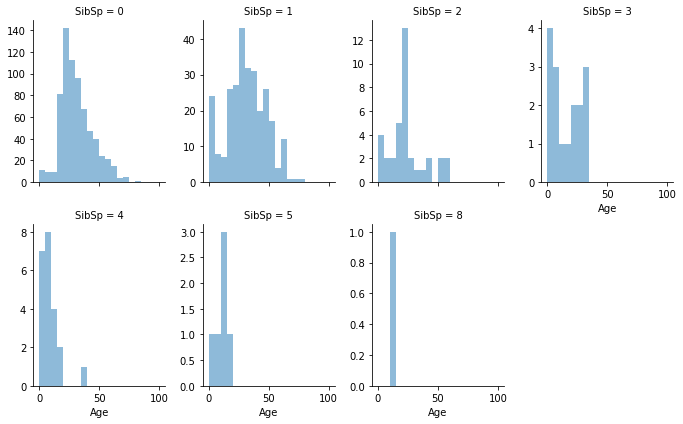

In [57]:
# visualize the correlation between SibSp and Age
grid = sns.FacetGrid(df, col='SibSp', col_wrap=4, size=3.0, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [58]:
# inspect the mean Age for each SibSp
df[['SibSp', 'Age']].groupby(['SibSp']).mean()

,Age
SibSp,
0,30.921766
1,31.058071
2,23.569444
3,16.312500
4,8.772727
5,10.166667
8,14.500000


In [59]:
# inspect the standard deviation of Age for each SibSp
df[['SibSp', 'Age']].groupby(['SibSp']).std()

,Age
SibSp,
0,13.059751
1,15.974482
2,14.910640
3,11.824938
4,8.005545
5,5.192944
8,NaN


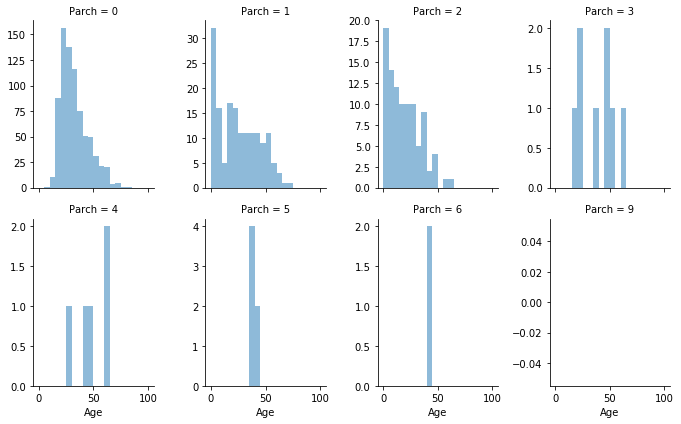

In [60]:
# visualize the correlation between Parch and Age
grid = sns.FacetGrid(df, col='Parch', col_wrap=4, size=3.0, aspect=0.8, sharey=False)
grid.map(plt.hist, 'Age', alpha=.5, bins=range(0,105,5))
plt.show()

In [61]:
# inspect the mean Age for each Parch
df[['Parch', 'Age']].groupby(['Parch']).mean()

,Age
Parch,
0,31.969401
1,24.965625
2,18.975979
3,38.875000
4,47.600000
5,39.333333
6,41.500000
9,NaN


In [62]:
# inspect the standard deviation of Age for each Parch
df[['Parch', 'Age']].groupby(['Parch']).std() 

,Age
Parch,
0,12.422617
1,18.410885
2,14.564066
3,16.295815
4,14.432602
5,1.032796
6,2.121320
9,NaN


In [63]:
# notice that instead of using Title, we should use its corresponding dummy variables 
df_sub = df[['Age','Master','Miss','Mr','Mrs','Others','Fare-bin','SibSp']]

X_train  = df_sub.dropna().drop('Age', axis=1)
y_train  = df['Age'].dropna()
X_test = df_sub.loc[np.isnan(df.Age)].drop('Age', axis=1)

regressor = RandomForestRegressor(n_estimators = 300)
regressor.fit(X_train, y_train)
y_pred = np.round(regressor.predict(X_test),1)
df.Age.loc[df.Age.isnull()] = y_pred

df.Age.isnull().sum(axis=0) # no more NAN now

C:\Users\HP-PC\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0

In [64]:
bins = [ 0, 4, 12, 18, 30, 50, 65, 100] # This is somewhat arbitrary
age_index = (1,2,3,4,5,6,7) #('baby','child','teenager','young','mid-age','over-50','senior')
df['Age-bin'] = pd.cut(df.Age, bins, labels=age_index).astype(int)

df[['Age-bin', 'Survived']].groupby(['Age-bin'],as_index=False).mean()

,Age-bin,Survived
0,1,0.675000
1,2,0.452381
2,3,0.402597
3,4,0.315789
4,5,0.427083
5,6,0.375000
6,7,0.125000


In [65]:
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.200000
4,5,0.000000
5,6,0.166667
6,7,0.111111
7,8,0.000000
8,9,1.000000
9,A,0.068966


In [66]:
df['Ticket'].value_counts()

3    429
2    278
1    210
P     98
S     98
C     77
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket, dtype: int64

In [67]:
df['Ticket'] = df['Ticket'].replace(['A','W','F','L','5','6','7','8','9'], '4')

# check the correlation again
df[['Ticket', 'Survived']].groupby(['Ticket'], as_index=False).mean()

,Ticket,Survived
0,1,0.630137
1,2,0.464481
2,3,0.239203
3,4,0.166667
4,C,0.340426
5,P,0.646154
6,S,0.323077


In [68]:
# dummy encoding
df = pd.get_dummies(df,columns=['Ticket'])

In [69]:
df

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Master,...,Family,Fare-bin,Age-bin,Ticket_1,Ticket_2,Ticket_3,Ticket_4,Ticket_C,Ticket_P,Ticket_S
0,22.0,7.2500,0,1,3,0,1,0.0,Mr,0,...,2,1,4,0,0,0,1,0,0,0
1,38.0,71.2833,0,2,1,1,1,1.0,Mrs,0,...,2,5,5,0,0,0,0,0,1,0
2,26.0,7.9250,0,3,3,1,0,1.0,Miss,0,...,1,2,4,0,0,0,0,0,0,1
3,35.0,53.1000,0,4,1,1,1,1.0,Mrs,0,...,2,5,5,1,0,0,0,0,0,0
4,35.0,8.0500,0,5,3,0,0,0.0,Mr,0,...,1,2,5,0,0,1,0,0,0,0
5,28.8,8.4583,0,6,3,0,0,0.0,Mr,0,...,1,2,4,0,0,1,0,0,0,0
6,54.0,51.8625,0,7,1,0,0,0.0,Mr,0,...,1,5,6,1,0,0,0,0,0,0
7,2.0,21.0750,1,8,3,0,3,0.0,Master,1,...,0,3,1,0,0,1,0,0,0,0
8,27.0,11.1333,2,9,3,1,0,1.0,Mrs,0,...,3,3,4,0,0,1,0,0,0,0
9,14.0,30.0708,0,10,2,1,1,1.0,Mrs,0,...,2,4,3,0,1,0,0,0,0,0


In [70]:
df = df.drop(labels=['SibSp','Parch','Age','Fare','Title'], axis=1)

In [84]:
df

,PassengerId,Pclass,Sex,Survived,Master,Miss,Mr,Mrs,Others,Family,Fare-bin,Age-bin,Ticket_1,Ticket_2,Ticket_3,Ticket_4,Ticket_C,Ticket_P,Ticket_S
0,1,3,0,0.0,0,0,1,0,0,2,1,4,0,0,0,1,0,0,0
1,2,1,1,1.0,0,0,0,1,0,2,5,5,0,0,0,0,0,1,0
2,3,3,1,1.0,0,1,0,0,0,1,2,4,0,0,0,0,0,0,1
3,4,1,1,1.0,0,0,0,1,0,2,5,5,1,0,0,0,0,0,0
4,5,3,0,0.0,0,0,1,0,0,1,2,5,0,0,1,0,0,0,0
5,6,3,0,0.0,0,0,1,0,0,1,2,4,0,0,1,0,0,0,0
6,7,1,0,0.0,0,0,1,0,0,1,5,6,1,0,0,0,0,0,0
7,8,3,0,0.0,1,0,0,0,0,0,3,1,0,0,1,0,0,0,0
8,9,3,1,1.0,0,0,0,1,0,3,3,4,0,0,1,0,0,0,0
9,10,2,1,1.0,0,0,0,1,0,2,4,3,0,1,0,0,0,0,0


In [71]:
df1 = df[0:891]

In [72]:
X = df1[0:891].drop(['Survived','PassengerId'], axis=1).values
Y = df1[0:891]['Survived'].values

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 2)

In [74]:
# Initialising the NN
model = Sequential()

# layers
model.add(Dense(16, kernel_initializer = 'uniform', activation = 'relu', input_dim = 17))
model.add(Dense(12, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                204       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 505
Trainable params: 505
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Compiling the NN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the NN
model.fit(X_train, y_train, batch_size = 32, epochs = 200)

Epoch 1/200
623/623 [==============================] - 0s 715us/step - loss: 0.6916 - acc: 0.6340
Epoch 2/200
623/623 [==============================] - 0s 39us/step - loss: 0.6862 - acc: 0.6244
Epoch 3/200
623/623 [==============================] - 0s 51us/step - loss: 0.6725 - acc: 0.6276
Epoch 4/200
623/623 [==============================] - 0s 45us/step - loss: 0.6409 - acc: 0.6918
Epoch 5/200
623/623 [==============================] - 0s 39us/step - loss: 0.5856 - acc: 0.7881
Epoch 6/200
623/623 [==============================] - 0s 51us/step - loss: 0.5237 - acc: 0.8058
Epoch 7/200
623/623 [==============================] - 0s 39us/step - loss: 0.4724 - acc: 0.8202
Epoch 8/200
623/623 [==============================] - 0s 45us/step - loss: 0.4390 - acc: 0.8331
Epoch 9/200
623/623 [==============================] - 0s 39us/step - loss: 0.4260 - acc: 0.8331
Epoch 10/200
623/623 [==============================] - 0s 39us/step - loss: 0.4171 - acc: 0.8315
Epoch 11/200
623/623 [======

623/623 [==============================] - 0s 39us/step - loss: 0.3583 - acc: 0.8587
Epoch 168/200
623/623 [==============================] - 0s 39us/step - loss: 0.3577 - acc: 0.8555
Epoch 169/200
623/623 [==============================] - 0s 39us/step - loss: 0.3575 - acc: 0.8604
Epoch 170/200
623/623 [==============================] - 0s 39us/step - loss: 0.3569 - acc: 0.8587
Epoch 171/200
623/623 [==============================] - 0s 39us/step - loss: 0.3571 - acc: 0.8587
Epoch 172/200
623/623 [==============================] - 0s 39us/step - loss: 0.3591 - acc: 0.8604
Epoch 173/200
623/623 [==============================] - 0s 39us/step - loss: 0.3560 - acc: 0.8539
Epoch 174/200
623/623 [==============================] - 0s 39us/step - loss: 0.3571 - acc: 0.8571
Epoch 175/200
623/623 [==============================] - 0s 39us/step - loss: 0.3558 - acc: 0.8571
Epoch 176/200
623/623 [==============================] - 0s 39us/step - loss: 0.3551 - acc: 0.8571
Epoch 177/200
623/623 [=

We can now produce the prediction.

In [76]:
y_pred = model.predict(X_test)
y_final = (y_pred > 0.5).astype(int).reshape(X_test.shape[0])

#output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': y_final})
#output.to_csv('prediction.csv', index=False)

In [77]:
df12345 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_final.flatten()})
df12345

,Actual,Predicted
0,1.0,0
1,0.0,0
2,1.0,1
3,0.0,0
4,1.0,0
5,0.0,0
6,1.0,0
7,0.0,0
8,1.0,1
9,0.0,0


In [78]:
from sklearn.metrics import accuracy_score
Accuracy = accuracy_score(y_test,y_final)
print("Accuracy:", Accuracy)

Accuracy: 0.8059701492537313


In [79]:
from sklearn.metrics import classification_report
C_report = classification_report(y_test,y_final)
print(C_report)

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85       160
         1.0       0.83      0.65      0.73       108

   micro avg       0.81      0.81      0.81       268
   macro avg       0.81      0.78      0.79       268
weighted avg       0.81      0.81      0.80       268



In [80]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_final))


[[146  14]
 [ 38  70]]


In [81]:
cm = confusion_matrix(y_test,y_final)
cm_df = pd.DataFrame(cm,
                     index = ['survived','Not'], 
                     columns = ['survived','Not'])

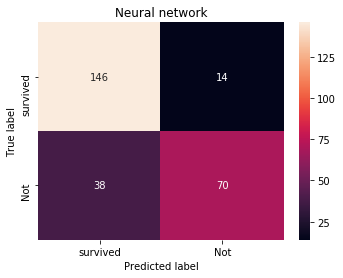

Accuracy: 0.8059701492537313


In [82]:
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True, fmt="d")
plt.title('Neural network'.format(accuracy_score(y_test, y_final)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('plot_NN.png', dpi=500, bbox_inches='tight')
plt.show()
print("Accuracy:",accuracy_score(y_test, y_final))

In [83]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_final)

0.5816522574447647